# Final porject
## Week 3 task 3-- Clustering Neighborhoods in Toronto

In [1]:
import numpy as np # library to handle data in a vectorized manner
import requests
import pandas as pd # library for data analsysis
from bs4 import BeautifulSoup

## 1.Read data from Wikipedia
We assume the first table in the webpage is the table we want

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
results = requests.get(url)
dfs=pd.read_html(results.text)
df=dfs[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Clean dataset


Remove unassigned postal code.

In [3]:
# remove rows with Borough = Not assigned
df.drop(df.index[df['Borough'] == 'Not assigned'], inplace = True)
df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Combine entries with the same postal code.

In [4]:
# combine the data with same postcode
d = {'Borough': 'first', 'Neighbourhood': ', '.join}
df= df.groupby('Postal Code', as_index = False).aggregate(d).reindex(columns=df.columns)
df.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Use borough name if neighbourhood name is not given. *(Assuming the borough itself is a neighbourhood)* 

In [5]:
# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
df['Neighbourhood'] = np.where(df['Neighbourhood'] == 'Not assigned', df['Borough'], df['Neighbourhood'])
df.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [6]:
df.shape

(103, 3)

## 2. Import geo-data

Read geodata stored in the csv file

In [7]:
# import data
path='data/'
file_name='Geospatial_Coordinates.csv'
df_geo=pd.read_csv(path+file_name)
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge two datasets base on postcode

In [8]:
df_merged = pd.merge(df,df_geo, on = 'Postal Code',how='outer')
print('df_merged.shape=', df_merged.shape)
df_merged.head()

df_merged.shape= (103, 5)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Work only on the data with 'Toronto' in the borough name

In [11]:
toronto_data=df_merged[df_merged['Borough'].str.contains("Toronto")]
print('toronto_data.shape=', df_reduced.shape)
toronto_data.head()

toronto_data.shape= (39, 5)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


## 2. Explore Neighborhoods in Toronto

#### Get coordinate of Toronto

In [48]:
from geopy.geocoders import Nominatim

address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Define Foursquare Credentials and Version


In [13]:
CLIENT_ID = 'VFA2B3AT12KFEZ1UNJYOJQSRGELNDRNZXX2RHPS0UF1LM0XT' # your Foursquare ID
CLIENT_SECRET = '0ORPFTJLTS1WO4H1E2JWL2KP0OK3DT4W0CDEYC1YIRAR45PI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VFA2B3AT12KFEZ1UNJYOJQSRGELNDRNZXX2RHPS0UF1LM0XT
CLIENT_SECRET:0ORPFTJLTS1WO4H1E2JWL2KP0OK3DT4W0CDEYC1YIRAR45PI


#### Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called toronto.

In [25]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High 

#### Let's check the size of the resulting dataframe


In [26]:
print(toronto_venues.shape)
toronto_venues.head()

(1624, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


Let's check how many venues were returned for each neighborhood


In [28]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,55,55,55,55,55,55
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,68,68,68,68,68,68
Christie,16,16,16,16,16,16
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


#### Let's find out how many unique categories can be curated from all the returned venues


In [29]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 237 uniques categories.


## 3. Analyze Each Neighborhood


In [30]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.


In [31]:
toronto_onehot.shape

(1624, 238)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [32]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.00,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.0625,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,Central Bay Street,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.014706,0.000000,0.000000,0.014706,0.00,0.014706
5,Christie,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,Church and Wellesley,0.013333,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.013333,0.000000,...,0.013333,0.000000,0.000000,0.00,0.000000,0.000000,0.013333,0.000000,0.00,0.026667
7,"Commerce Court, Victoria Hotel",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.040000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.00,0.000000
8,Davisville,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.030303,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,Davisville North,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000


#### Let's confirm the new size


In [33]:
toronto_grouped.shape

(39, 238)

#### Let's print each neighborhood along with the top 5 most common venues


In [34]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
            venue  freq
0     Coffee Shop  0.09
1    Cocktail Bar  0.04
2        Beer Bar  0.04
3  Farmers Market  0.04
4     Cheese Shop  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.13
1  Breakfast Spot  0.09
2     Coffee Shop  0.09
3       Nightclub  0.09
4       Pet Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0  Gym / Fitness Center  0.06
1         Auto Workshop  0.06
2           Pizza Place  0.06
3            Comic Shop  0.06
4      Recording Studio  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0       Airport Lounge  0.12
1      Airport Service  0.12
2  Rental Car Location  0.06
3        Boat or Ferry  0.06
4   Airport Food Court  0.06


----Central Bay Street----
                venue  freq
0         Coff

#### Let's put that into a _pandas_ dataframe


First, let's write a function to sort the venues in descending order.


In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [67]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Bakery,Beer Bar,Farmers Market,Restaurant,Cheese Shop,Basketball Stadium,Sporting Goods Shop
1,"Brockton, Parkdale Village, Exhibition Place",Café,Nightclub,Coffee Shop,Breakfast Spot,Grocery Store,Intersection,Bar,Bakery,Italian Restaurant,Climbing Gym
2,"Business reply mail Processing Centre, South C...",Gym / Fitness Center,Auto Workshop,Comic Shop,Park,Pizza Place,Recording Studio,Restaurant,Butcher,Burrito Place,Brewery
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Boutique,Plane,Airport,Airport Food Court,Airport Gate,Airport Terminal,Bar,Harbor / Marina
4,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Salad Place,Department Store,Thai Restaurant,Burger Joint,Bubble Tea Shop,Japanese Restaurant


## 4. Cluster Neighborhoods


Run _k_-means to cluster the neighborhood into 5 clusters.


In [68]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [69]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,4,Pub,Health Food Store,Trail,Neighborhood,Yoga Studio,Distribution Center,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Italian Restaurant,Restaurant,Ice Cream Shop,Furniture / Home Store,Bookstore,Juice Bar,Spa,Pub
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,1,Park,Sushi Restaurant,Fish & Chips Shop,Steakhouse,Pub,Brewery,Fast Food Restaurant,Italian Restaurant,Restaurant,Pizza Place
43,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Coffee Shop,American Restaurant,Bakery,Brewery,Café,Gastropub,Yoga Studio,Fish Market,Park,Neighborhood
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Park,Bus Line,Swim School,Dim Sum Restaurant,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


Finally, let's visualize the resulting clusters


In [86]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
latitude
longitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
m=map_clusters
m

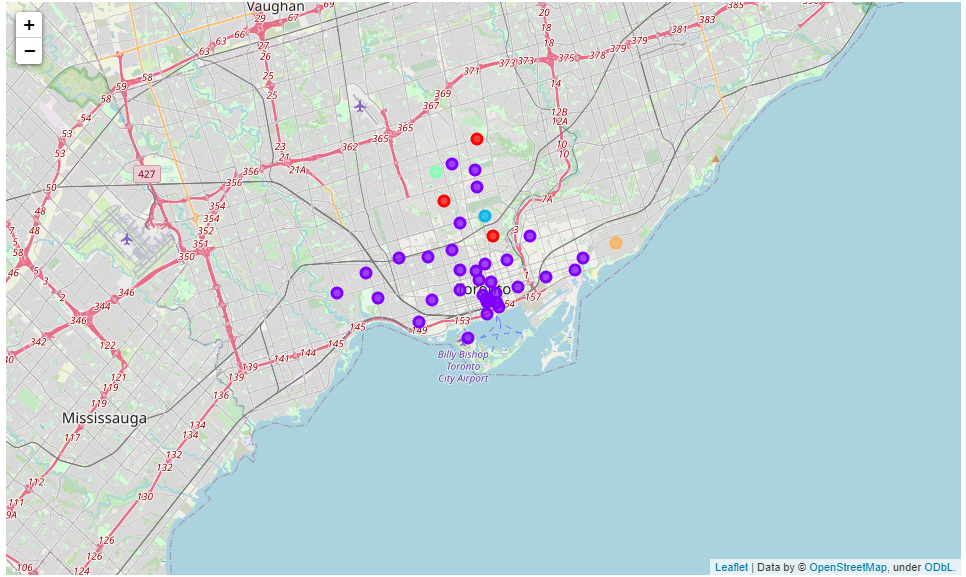

## 5. Examine Clusters


Now, we examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

#### Cluster 1


In [71]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Lawrence Park,0,Park,Bus Line,Swim School,Dim Sum Restaurant,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
50,Rosedale,0,Park,Playground,Trail,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
64,"Forest Hill North & West, Forest Hill Road Park",0,Park,Jewelry Store,Trail,Sushi Restaurant,Yoga Studio,Dessert Shop,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


#### Cluster 2


In [72]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,"The Danforth West, Riverdale",1,Greek Restaurant,Coffee Shop,Italian Restaurant,Restaurant,Ice Cream Shop,Furniture / Home Store,Bookstore,Juice Bar,Spa,Pub
42,"India Bazaar, The Beaches West",1,Park,Sushi Restaurant,Fish & Chips Shop,Steakhouse,Pub,Brewery,Fast Food Restaurant,Italian Restaurant,Restaurant,Pizza Place
43,Studio District,1,Coffee Shop,American Restaurant,Bakery,Brewery,Café,Gastropub,Yoga Studio,Fish Market,Park,Neighborhood
45,Davisville North,1,Gym / Fitness Center,Sandwich Place,Park,Department Store,Breakfast Spot,Dance Studio,Hotel,Dog Run,Food & Drink Shop,Distribution Center
46,"North Toronto West, Lawrence Park",1,Coffee Shop,Clothing Store,Yoga Studio,Bagel Shop,Furniture / Home Store,Ice Cream Shop,Fast Food Restaurant,Diner,Mexican Restaurant,Chinese Restaurant
47,Davisville,1,Sandwich Place,Dessert Shop,Pizza Place,Café,Italian Restaurant,Gym,Coffee Shop,Sushi Restaurant,Pharmacy,Indian Restaurant
49,"Summerhill West, Rathnelly, South Hill, Forest...",1,Coffee Shop,Pizza Place,Light Rail Station,Liquor Store,Restaurant,Bank,Bagel Shop,Pub,Supermarket,Fried Chicken Joint
51,"St. James Town, Cabbagetown",1,Coffee Shop,Restaurant,Pizza Place,Café,Italian Restaurant,Chinese Restaurant,Park,Market,Bakery,Pub
52,Church and Wellesley,1,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Pub,Men's Store,Mediterranean Restaurant,Hotel,Yoga Studio
53,"Regent Park, Harbourfront",1,Coffee Shop,Pub,Bakery,Park,Breakfast Spot,Café,Theater,Yoga Studio,Event Space,Restaurant


#### Cluster 3


In [73]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,"Moore Park, Summerhill East",2,Playground,Trail,Yoga Studio,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


#### Cluster 4

In [74]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Roselawn,3,Music Venue,Garden,Yoga Studio,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


#### Cluster 5

In [75]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,The Beaches,4,Pub,Health Food Store,Trail,Neighborhood,Yoga Studio,Distribution Center,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
